## Sentinel-2 crop

In [44]:
service = dict([('title', 'S2 CROP'),
                ('abstract', 'Sentinel-2 crop'),
                ('id', 's2_crop')])

In [45]:
pa_code = dict([('id', 'pa_code'),
               ('value', 'DO'),
               ('title', 'Protected Area code'),
               ('abstract', 'Protected Area code (one of DO,CA,...)')])

In [46]:
pa_name = dict([('id', 'pa_name'),
               ('value', 'Donana'),
               ('title', 'Protected Area name'),
               ('abstract', 'Protected Area name (one of Donana,...)')])

In [ ]:
pa_wkt = dict([('id', 'pa_wkt'),
               ('value', 'POLYGON((-6.79440295589744 37.1191319871777,-6.80827154725944 37.1673031942056,-6.72121114356795 37.2425767108835,-6.71042775152577 37.2930498879682,-6.73405462341917 37.3301447063348,-6.71685147187095 37.3522253716156,-6.67435624435345 37.3534492963332,-6.64461873043217 37.3365633914571,-6.62625336367183 37.3569789562915,-6.59581018720718 37.3506994424118,-6.58125246058411 37.3703051383248,-6.492413660497 37.3590379521576,-6.4716624422663 37.3807359777278,-6.43859705183134 37.368908852933,-6.44398095303713 37.347088527492,-6.42200724935979 37.3329929700694,-6.37035012694059 37.3583637388823,-6.33153540861988 37.3329986280188,-6.25703879672152 37.3486795386779,-6.2123425985781 37.3266608721382,-6.1976208676784 37.283024780795,-6.17366048732846 37.2660742144794,-6.15177710683581 37.2667431439207,-6.14475916204647 37.3055642119627,-6.1153577846492 37.3105672777454,-6.04475036124726 37.2771976083931,-6.04063041298302 37.2060457158668,-6.01561413928283 37.1744528799079,-6.03401959555254 37.1582677514823,-6.01528760169561 37.1211642619874,-6.03587498721126 37.0508366627984,-6.08415258431292 37.0557470251154,-6.1443715598251 37.0182321851901,-6.20489081698833 36.9013662293736,-6.24848183495607 36.8846441975983,-6.28133674315331 36.9000390906331,-6.27285487885334 36.8641095189495,-6.21240564569216 36.8569441225281,-6.19273049982008 36.8273222937041,-6.23650318117893 36.7815132843624,-6.25972339425557 36.7794168824025,-6.29452828553456 36.7134050019461,-6.32211152509425 36.693679078589,-6.40354402587554 36.7535989999008,-6.39366914786855 36.7750231637474,-6.42465019950879 36.7928589511795,-6.48913510482893 36.9063367348853,-6.55574132052792 36.9640015939793,-6.54729285159512 36.9812830814621,-6.79440295589744 37.1191319871777))'),
               ('title', 'Protected Area wkt'),
               ('abstract', 'Protected Area wkt')])

In [ ]:
start = dict([('id', 'start'),
              ('value', '2018-05-17T00:00:00Z'),
              ('title', 'start date for dataset selection'),
              ('abstract', 'start date for dataset selection')])

In [ ]:
stop = dict([('id', 'stop'),
            ('value', '2018-05-17T23:59:59Z'),
            ('title', 'stop date for dataset selection'),
            ('abstract', 'stop date for dataset selection')])

In [ ]:
cat_index = dict([('id', 'cat_index'),
              ('value', 'ecop-cnr-issia'),
              ('title', 'publishing catalog index'),
              ('abstract', 'publishing catalog index')])

In [ ]:
config_url = dict([('id', 'config_url'),
                   ('value', 'https://store.terradue.com/ec-ecopotential/config/'),
                   ('title', 'FTP configuration file URL'),
                   ('abstract', 'FTP configuration file URL')])

In [51]:
shapefile_url = dict([('id', 'shapefile_url'),
                      ('value', 'https://store.terradue.com/ec-ecopotential/PAs/Shapefiles/Donana/Donana_Biosfera_LatLonWGS84.shp'),
                      ('title', 'Protected Area name shape file download URL'),
                      ('abstract', 'Protected Area name shape file download URL')])

In [ ]:
username = dict([('id', 'username'),
                 ('value', 'msagona'),
                 ('title', 'username for DA access'),
                 ('abstract', 'username for DA access')])

In [52]:
api_key  = dict([('id', 'api_key'),
                 ('value', 'AKCp2V6wov45FKVuto1g558a3QKv5ZX4aD4vieCoZP8PtBU2TSFF2pBx57grLHp6zJuTY67S1'),
                 ('title', 'apikey for DA access'),
                 ('abstract', 'apikey for DA access')])

In [53]:
percentage_threshold = dict([('id', 'percentage_threshold'),
                           ('value', '100.0'),
                           ('title', 'Cloud percentage threshold'),
                           ('abstract', 'Cloud percentage threshold')])

In [50]:
ftp_server_basepath = 'sftp://frontend.recas.ba.infn.it/lustre/ecopotential/incoming/PAs'

In [47]:
data_path = '/workspace/data'

In [48]:
input_identifier = 'S2A_MSIL1C_20170909T110651_N0205_R137_T30STF_20170909T111217'
#input_identifier = 'S2B_MSIL1C_20180502T110619_N0206_R137_T29SQB_20180502T121756'

In [54]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import snappy
import dateutil.parser as parser
import gc
from datetime import datetime
import matplotlib
import matplotlib.colors as colors

from os.path import basename
import gdal
import osr
import warnings
warnings.filterwarnings("ignore")
import zipfile

%matplotlib inline

In [55]:
import sys

sys.path.append('/application/notebook/libexec/') 
sys.path.append(os.getcwd())
import ISOMetadata

In [56]:
s2prd = "%s/%s/%s.SAFE/MTD_MSIL1C.xml" % (data_path, input_identifier, input_identifier)
product = snappy.ProductIO.readProduct(s2prd)

width = product.getSceneRasterWidth()
height = product.getSceneRasterHeight()
name = product.getName()
description = product.getDescription()
band_names = product.getBandNames()


In [57]:
product_date = parser.parse(product.getStartTime().toString()).date()

In [58]:
output_date = '%s%02d%02d' % (product_date.year, product_date.month, product_date.day)
date_path = '%s/%02d/%02d' % (product_date.year, product_date.month, product_date.day)
    
middle_path = '%s/EO_Data/Sentinel2/Raw'%pa_name['value']
        
ftp_remote_path = os.path.join(ftp_server_basepath, date_path)
zip_output_name = '%s_PA_%s_CROP.zip' % (name, pa_name['value'])
download_URL = '%s/%s' %(ftp_remote_path, zip_output_name)

Getting Shapefile from store

In [59]:
import warnings
import requests
warnings.filterwarnings("ignore")
import shapefile
from shapely.geometry import shape

try:
    r = requests.get(shapefile_url['value'],headers={"X-JFrog-Art-Api":store_api_key['value'], 'User-Agent': 'curl/t2Client'})

    if r.status_code == 200:
        if r.content:
            shapef = os.path.basename(shapefile_url['value']) 
            with open(shapef,"wb") as f:
                for chunk in r.iter_content(chunk_size=1024):
                    # writing one chunk at a time to pdf file
                    if chunk:
                        f.write(chunk)
                f.close()
    else:
        raise ValueError
except :
    shapef = os.path.join(os.path.join(data_path,'Donana_SHP/LatLonWGS84'),os.path.basename(shapefile_url['value']))
    print shapef
            
shapeIN = shapefile.Reader(shapef)
feature = shapeIN.shapeRecords()[0]
first = feature.shape.__geo_interface__  

shp_geom = shape(first)


/workspace/data/Donana_SHP/LatLonWGS84/Donana_Biosfera_LatLonWGS84.shp


ADDING SHAPE VECTOR BAND TO PRODUCT

In [60]:
separateShapes = False

snappy.GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()
HashMap = snappy.jpy.get_type('java.util.HashMap')
parameters = HashMap()
parameters.put('vectorFile', shapef)
parameters.put('separateShapes', separateShapes)

new_product = snappy.GPF.createProduct('Import-Vector', parameters, product)


### Cloud coverage analysis over the cropped area

In [61]:
snappy.GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

HashMap = snappy.jpy.get_type('java.util.HashMap')

parameters = HashMap()
parameters.put('referenceBand', 'B1')

resampleB1 = snappy.GPF.createProduct('Resample', parameters, product)

In [62]:
HashMap = snappy.jpy.get_type('java.util.HashMap')

BandDescriptor = snappy.jpy.get_type('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor')

targetBand0 = BandDescriptor()
targetBand0.name = 'cloud_mask'
targetBand0.type = 'uint16'
targetBand0.expression = 'opaque_clouds_60m'


targetBands = snappy.jpy.array('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor', 1)
targetBands[0] = targetBand0

 
parameters = HashMap()
parameters.put('targetBands', targetBands)

cloud_mask = snappy.GPF.createProduct('BandMaths', parameters, resampleB1)

In [63]:
WKTReader = snappy.jpy.get_type('com.vividsolutions.jts.io.WKTReader')

geom = WKTReader().read(str(shp_geom))


parameters = HashMap()
parameters.put('copyMetadata', True)
parameters.put('geoRegion', geom)
    
cloud_mask_geo = snappy.GPF.createProduct('Subset', parameters, cloud_mask)

mask_geo_output_name = '%s_%s_MASK_%s.tif' % (name, pa_code['value'], '60')
snappy.ProductIO.writeProduct(cloud_mask_geo, mask_geo_output_name, 'GeoTIFF')


In [64]:
import gdalnumeric
raster_file = gdalnumeric.LoadFile(mask_geo_output_name)
print raster_file.min(), raster_file.max()
pixel_count_cloud_geo = (raster_file == 255).sum()  # for pixel value = 1
print pixel_count_cloud_geo
cloud_percent =  float(pixel_count_cloud_geo) / float(raster_file.size) * 100.0

0 255
144290


In [65]:
cloud_percent

84.74735549956243

In [66]:
mask_output_name = '%s_MASK_%s.tif' % (name, '60')
snappy.ProductIO.writeProduct(cloud_mask, mask_output_name, 'GeoTIFF')
import gdalnumeric
raster_file = gdalnumeric.LoadFile(mask_output_name)
print raster_file.min(), raster_file.max()
pixel_count_cloud = (raster_file == 255).sum()  # for pixel value = 1
print pixel_count_cloud
cloud_percent_mask =  float(pixel_count_cloud) / float(raster_file.size) * 100.0
print cloud_percent_mask

0 255
2496964
74.5607214309


In [67]:
cloud_mask_geo = None
raster_file = None

gc.collect()

0

### Crop

In [68]:
if cloud_percent <= percentage_threshold['value']:
    
    snappy.GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

    HashMap = snappy.jpy.get_type('java.util.HashMap')

    WKTReader = snappy.jpy.get_type('com.vividsolutions.jts.io.WKTReader')
    #geom = WKTReader().read(str(shp_geom))
    geom = WKTReader().read(wkt['value'])
    
    subsets = []
    geotiffs = []
    
    for band in list(band_names)[0:13]:

        BandDescriptor = snappy.jpy.get_type('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor')

        parameters = HashMap()
        parameters.put('referenceBand', band)

        resample = snappy.GPF.createProduct('Resample', parameters, new_product)

        parameters = HashMap()
        parameters.put('copyMetadata', True)
        parameters.put('sourceBands', band)

        subset = snappy.GPF.createProduct('Subset', parameters, resample)

        parameters = HashMap()
        parameters.put('copyMetadata', True)
        parameters.put('geoRegion', geom)

        subset_geo = snappy.GPF.createProduct('Subset', parameters, subset)

        subsets.append(subset_geo)

        #output_name = 'S2A_USER_PRD_MSIL1C_%s_%s_CROP_%s.tif' % (output_date, pa_code['value'], band)
        output_name = '%s_PA_%s_CROP_%s.tif' % (name, pa_name['value'], band)
        geotiffs.append(output_name)

        snappy.ProductIO.writeProduct(subset_geo, output_name, 'GeoTIFF')
        

In [69]:
%matplotlib inline

def plotTiff(filename):

    data = gdal.Open(filename)
    bnd1 = data.GetRasterBand(1)

    img1 = bnd1.ReadAsArray(0,0,data.RasterXSize, data.RasterYSize)
    
    imgplot = plt.imshow(img1, cmap=plt.cm.binary_r)    
    
    return imgplot

In [70]:
%matplotlib inline

def plotBand(product, band, vmin, vmax):
    
    band = product.getBand(band)

    w = band.getRasterWidth()
    h = band.getRasterHeight()
    
    band_data = np.zeros(w * h, np.float32)
    band.readPixels(0, 0, w, h, band_data)

    band_data.shape = h, w

    imgplot = plt.imshow(band_data, cmap=plt.cm.binary_r, vmin=vmin, vmax=vmax)

    
    return imgplot 


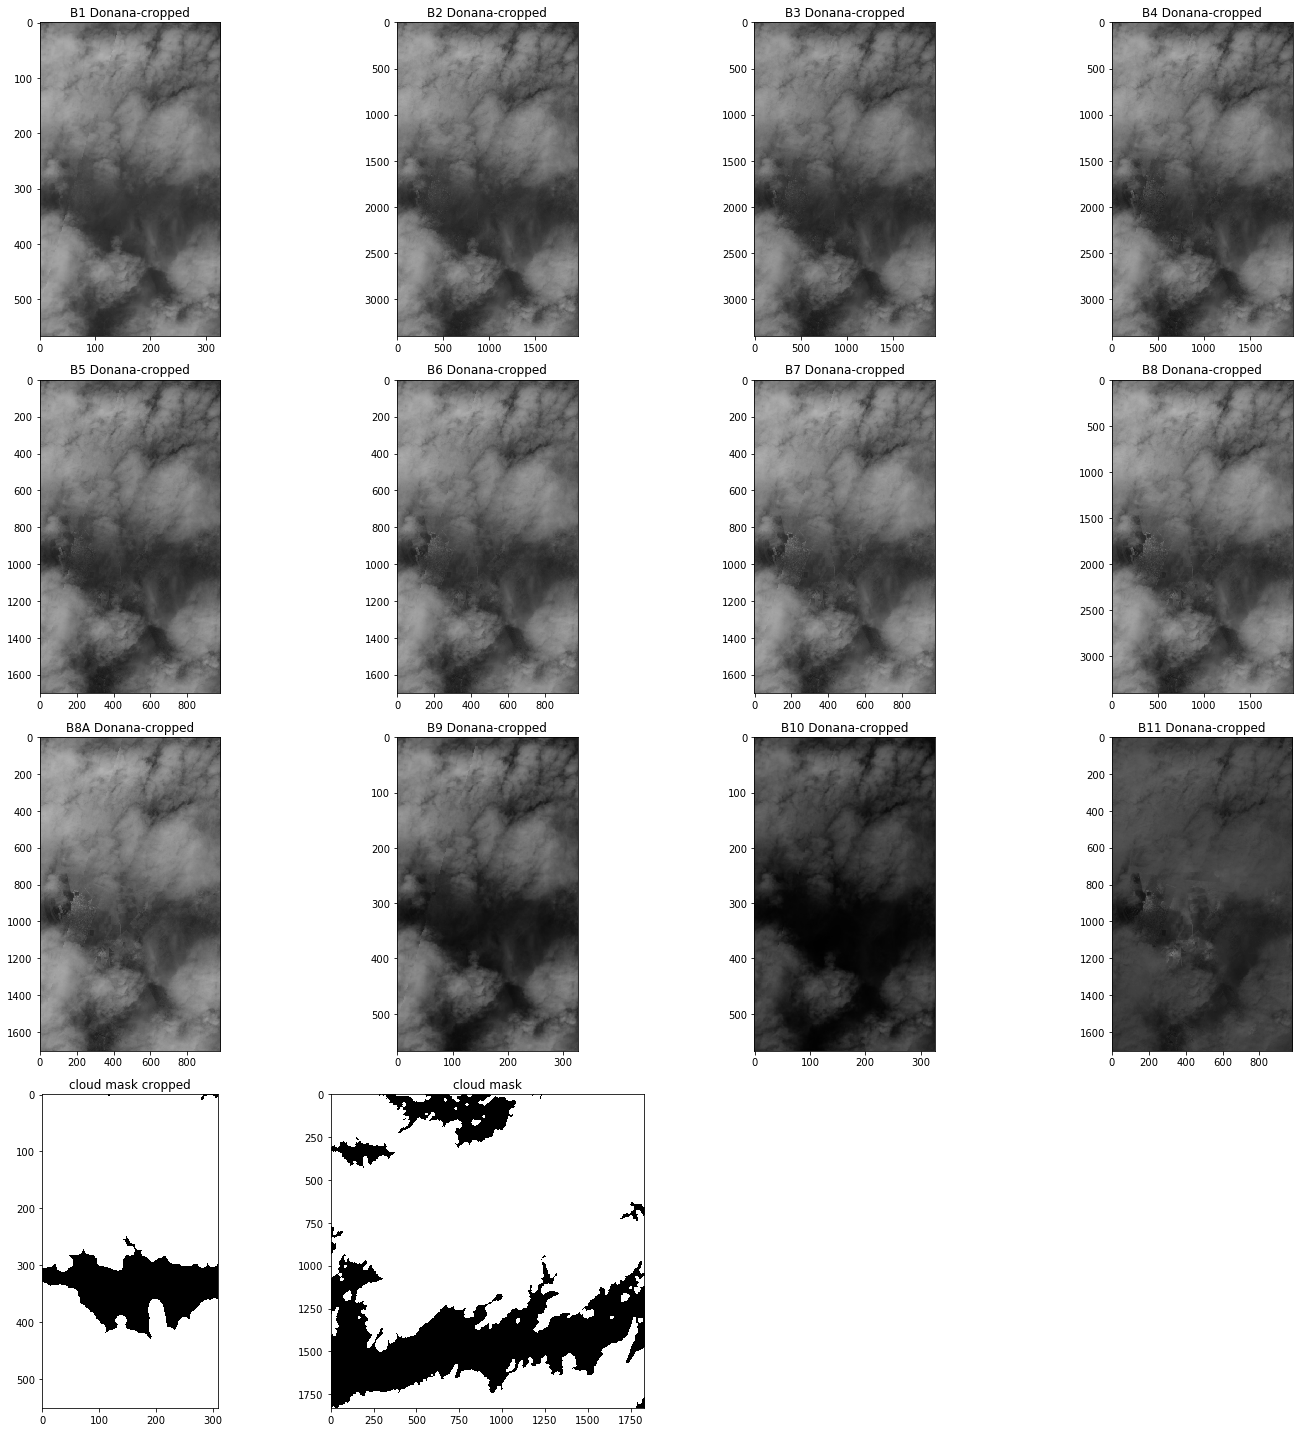

In [71]:
if True:
    fig = plt.figure(figsize=(20,20))
    for index, subset in enumerate(subsets):
        a=fig.add_subplot(4,4,index+1)
        imgplot = plotBand(subset, band_names[index], 0, 1)
        nameB = band_names[index]
        #a.set_title(name)
        #band = band_names[index]
        #fname='%s_PA_%s_CROP_%s.tif' % (name, pa_name['value'], band)
        #imgplot = plotTiff(fname)
        a.set_title('%s %s-cropped' %(nameB, pa_name['value']))
    
    a=fig.add_subplot(4,4,index+1)
    imgplot = plotTiff(mask_geo_output_name)
    a.set_title('cloud mask cropped')
    
    a=fig.add_subplot(4,4,index+2)
    imgplot = plotTiff(mask_output_name)
    a.set_title('cloud mask')
    
    plt.tight_layout()
    fig = plt.gcf() 
    plt.show()

    fig.clf()
    plt.close()
    gc.collect()
    

In [72]:
def set_dates(start_date,end_date):
    
    #iso_metadata.set_start_date(parser.parse(subset.getStartTime().toString()).isoformat())
    #iso_metadata.set_end_date(parser.parse(subset.getEndTime().toString()).isoformat())
    iso_metadata.set_start_date(start_date)
    iso_metadata.set_end_date(end_date)

In [73]:
def set_info(short_name, title, abstract):
    
    #short_name = os.path.splitext(basename(geotiff))[0]
    
    iso_metadata.set_identifier(short_name)
    #band = 'B1'
    #iso_metadata.set_title('Sentinel 2 Level 1C Band %s' % band)
    #iso_metadata.set_abstract('Sentinel 2 Level 1C Top of Atmosphere Reflectance for Band %s' % band)
    iso_metadata.set_title(title)
    iso_metadata.set_abstract(abstract)

In [74]:
def set_geo(geotiff):
    
    ds = gdal.Open(geotiff)

    iso_metadata.set_col_size(str(ds.RasterXSize))
    iso_metadata.set_row_size(str(ds.RasterYSize))

    transform = ds.GetGeoTransform()

    iso_metadata.set_pixel_size(str(transform[1]))

    ul_x = transform[0]
    ul_y = transform[3]

    nw_corner = '%s %s' % (str(ul_x), str(ul_y))

    iso_metadata.set_nw_corner(nw_corner)

    lr_x = transform[0] + transform[1] * ds.RasterXSize
    lr_y = transform[3] + transform[5] * ds.RasterYSize

    se_corner = '%s %s' % (str(lr_x), str(lr_y))

    iso_metadata.set_se_corner(se_corner)

    
    
    old_cs= osr.SpatialReference()
    old_cs.ImportFromWkt(ds.GetProjectionRef())

    wgs84_wkt = """
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.01745329251994328,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]"""
    new_cs = osr.SpatialReference()
    new_cs .ImportFromWkt(wgs84_wkt)

    transform = osr.CoordinateTransformation(old_cs,new_cs) 

    min_lon = transform.TransformPoint(ul_x,lr_y)[0]
    iso_metadata.set_min_lon(str(min_lon))

    min_lat = transform.TransformPoint(ul_x,lr_y)[1]
    iso_metadata.set_min_lat(str(min_lat))

    max_lon = transform.TransformPoint(lr_x, ul_y)[0]
    iso_metadata.set_max_lon(str(max_lon))

    max_lat = transform.TransformPoint(lr_x, ul_y)[1]
    iso_metadata.set_max_lat(str(max_lat))
    
    prj = ds.GetProjection()
    srs=osr.SpatialReference(wkt=prj)


    iso_metadata.set_epsg_code(srs.GetAttrValue("PROJCS|AUTHORITY", 1))

In [75]:
def write_properties(properties_file):
    
    properties = open(properties_file + '.properties', 'w')

    properties.write('identifier=' + geotiff)
    properties.write('\n')
    properties.write('date=%s/%s' % (parser.parse(subset.getStartTime().toString()).isoformat(), 
                                 parser.parse(subset.getEndTime().toString()).isoformat()))
    properties.write('\n')
    properties.write('category=%s,http://www.terradue.com/api/data-pipeline/results,%s Protected Area resource' % (pa_code['value'], pa_name['value']))
 
    properties.close()

In [76]:
if cloud_percent <= percentage_threshold['value']:
    iso_metadata = ISOMetadata.ISOMetadata()
    iso_metadata.set_contact('info@terradue.com')
    iso_metadata.set_date(output_date)
    iso_metadata.set_data_format('GEOTIFF')
    iso_metadata.set_data_type('UInt16')
    iso_metadata.set_pa(pa_name['value'])
    iso_metadata.set_data_quality('Nominal')
    iso_metadata.set_responsible_party('CNR')
    iso_metadata.set_onlineResource(download_URL)

In [77]:
if cloud_percent <= percentage_threshold['value']:
        
    for index, geotiff in enumerate(geotiffs):
        
        subset = subsets[index]
        
        start_date = parser.parse(subset.getStartTime().toString()).isoformat()
        end_date = parser.parse(subset.getEndTime().toString()).isoformat()
        
        set_dates(start_date,end_date)
        
        short_name = os.path.splitext(basename(geotiff))[0]
        band = band_names[index]
        title = 'Sentinel 2 Level 1C Band %s' % band
        abstract = 'Sentinel 2 Level 1C Top of Atmosphere Reflectance for Band %s' % band
        
        set_info(short_name, title, abstract)

        set_geo(geotiff)

        iso_metadata.write(os.path.splitext(basename(geotiff))[0] + '.xml')

        write_properties(basename(geotiff))
    

Zipping the cropped bands and related metadata

In [78]:
if cloud_percent <= percentage_threshold:  
    
    zip_output_name = '%s_PA_%s_CROP.zip' % (name, pa_name['value'])
    zf = zipfile.ZipFile(zip_output_name, mode='w')
    try:
        for geotiff in geotiffs:
            short_name = os.path.splitext(basename(geotiff))[0]
            #print '%s %s.properties %s.xml' %(geotiff,geotiff,short_name)
            zf.write(geotiff)
            zf.write('%s.properties' %geotiff)
            zf.write('%s.xml' %short_name)
    finally:
        #print 'closing'
        zf.close()


WRITING GENERAL XML

In [79]:
if cloud_percent <= percentage_threshold['value']:
    
    #dates are always the same, I can use the last one
    set_dates(start_date,end_date)
    
    short_name = os.path.splitext(zip_output_name)[0]
    title = 'Sentinel 2 Level 1C %s (cropped Bands) ' % name
    abstract = 'Sentinel 2 Level 1C Top of Atmosphere Reflectance for 13 Bands cropped over %s' % pa_name['value']
        
    set_info(short_name, title, abstract)

    #set_geo(geotiff)

    iso_metadata.write(os.path.splitext(zip_output_name)[0] + '.xml')